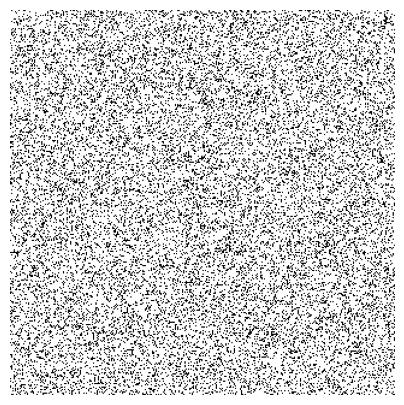

ULA iter    0, grad_norm=1.075e+05, sample_mean=3.125e-03, sample_std=1.946e-03
ULA iter   25, grad_norm=1.221e+05, sample_mean=3.124e-03, sample_std=1.963e-03
ULA iter   50, grad_norm=1.342e+05, sample_mean=3.125e-03, sample_std=1.977e-03
ULA iter   75, grad_norm=1.450e+05, sample_mean=3.125e-03, sample_std=1.993e-03
ULA iter  100, grad_norm=1.544e+05, sample_mean=3.124e-03, sample_std=2.006e-03
ULA iter  125, grad_norm=1.630e+05, sample_mean=3.124e-03, sample_std=2.020e-03
ULA iter  150, grad_norm=1.709e+05, sample_mean=3.125e-03, sample_std=2.032e-03
ULA iter  175, grad_norm=1.779e+05, sample_mean=3.125e-03, sample_std=2.044e-03
ULA iter  200, grad_norm=1.843e+05, sample_mean=3.126e-03, sample_std=2.055e-03
ULA iter  225, grad_norm=1.904e+05, sample_mean=3.125e-03, sample_std=2.066e-03
ULA iter  250, grad_norm=1.962e+05, sample_mean=3.124e-03, sample_std=2.078e-03
ULA iter  275, grad_norm=2.011e+05, sample_mean=3.124e-03, sample_std=2.089e-03
ULA iter  300, grad_norm=2.059e+05, samp

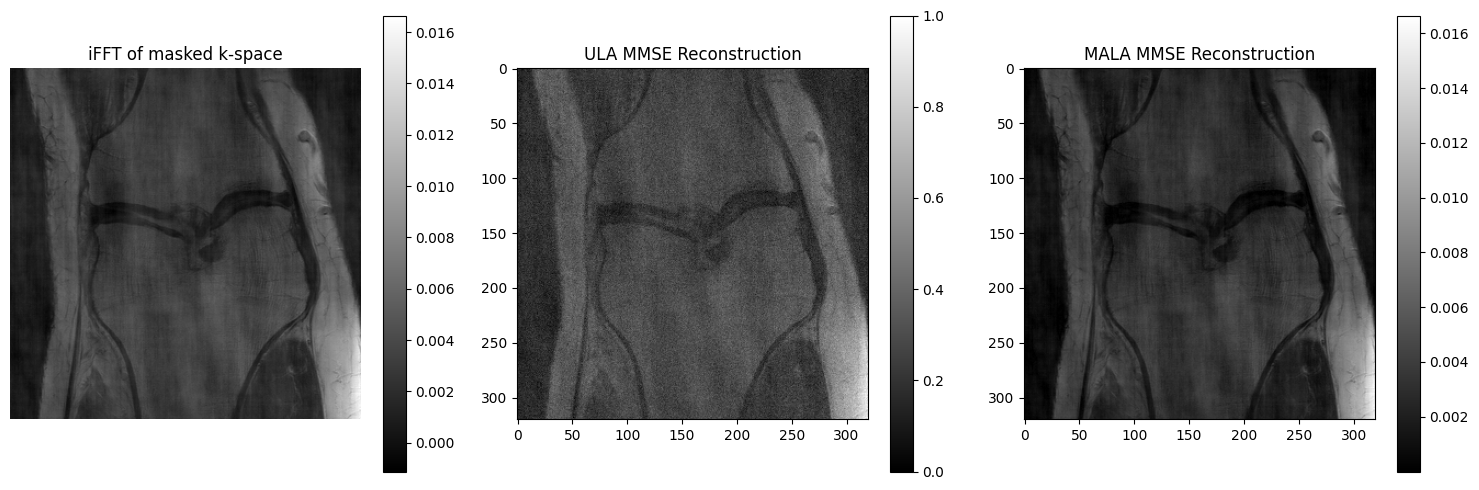

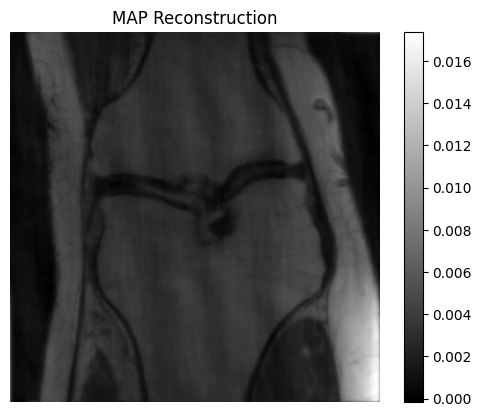

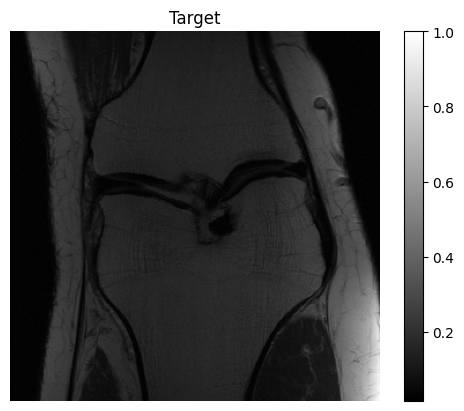

PSNR iFFT: -17.06 dB
None
PSNR MAP: -17.35 dB
None
ULA iter    0, grad_norm=1.075e+05, sample_mean=3.125e-03, sample_std=1.946e-03
ULA iter   25, grad_norm=1.221e+05, sample_mean=3.126e-03, sample_std=1.961e-03
ULA iter   50, grad_norm=1.346e+05, sample_mean=3.127e-03, sample_std=1.976e-03
ULA iter   75, grad_norm=1.453e+05, sample_mean=3.126e-03, sample_std=1.990e-03
ULA iter  100, grad_norm=1.548e+05, sample_mean=3.127e-03, sample_std=2.003e-03
ULA iter  125, grad_norm=1.635e+05, sample_mean=3.125e-03, sample_std=2.017e-03
ULA iter  150, grad_norm=1.711e+05, sample_mean=3.126e-03, sample_std=2.029e-03
ULA iter  175, grad_norm=1.784e+05, sample_mean=3.126e-03, sample_std=2.040e-03
ULA iter  200, grad_norm=1.850e+05, sample_mean=3.126e-03, sample_std=2.053e-03
ULA iter  225, grad_norm=1.906e+05, sample_mean=3.127e-03, sample_std=2.064e-03
ULA iter  250, grad_norm=1.962e+05, sample_mean=3.126e-03, sample_std=2.074e-03
ULA iter  275, grad_norm=2.017e+05, sample_mean=3.127e-03, sample_std

In [1]:
import os
import sys
import fastmri
import fastmri.data
import fastmri.data.transforms
import h5py
from sympy import not_empty_in
import torch

# Set the path to the root of your project
project_root = os.path.abspath(os.path.join(os.getcwd(), r"C:\Users\kostanjsek\bachelor_project"))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import numpy as np
import matplotlib.pyplot as plt
from utilities.masks import (
    CenteredBernoulliMask,
    BernoulliMask,
    UniformColumnMask,
    VariableDensityMask,
    PseudoRandomColumnMask,
    RadialMask
)
from fastmri.data import transforms as T
from utilities.metrics import psnr, stats
from fastmri.data.subsample import MaskFunc, RandomMaskFunc
from MAP.map_tv_minimize import MAPEstimator
from fastmri.data.mri_data import SliceDataset
from data.load_knee_mri import load_fastmri_data
from MMSE.mmse_ula import MMSEEstimatorULA
from MMSE.mmse_mala import MMSEEstimatorMALA
import skimage as ski

shepp_logan = ski.data.shepp_logan_phantom()

train_dataset, val_dataset, test_dataset = load_fastmri_data(
    r"C:\Users\kostanjsek\Documents\knee_mri"
)

file_name = r"C:\Users\kostanjsek\Documents\knee_mri\knee_singlecoil_train\singlecoil_train/file1000662.h5"
hf = h5py.File(file_name)

volume_kspace = hf['kspace'][()]
target = hf['reconstruction_rss'][()]

slice_kspace = volume_kspace[20]
slice_target = target[20]  # match slice index to kspace slice
tensor_kspace = T.to_tensor(slice_kspace)

mask = BernoulliMask(0.8, seed=42).generate(slice_target.shape)
#mask = CenteredBernoulliMask(0.5, 0.2, seed=42).generate(slice_target.shape)
#mask = VariableDensityMask('gaussian', 0.5, seed=30).generate(slice_target.shape)
#mask = PseudoRandomColumnMask(slice_target.shape, 2, 0.15, seed=30).get_mask()
#mask = CenteredBernoulliMask(0.75, 0.25, seed=30).generate(slice_target.shape) # used in fatmri_test.ipynb
#mask = UniformColumnMask(slice_target.shape, 8, seed=42).get_mask()
#mask = RadialMask(slice_target.shape, 100, 0.16).generate()

y = mask * np.fft.fft2(slice_target, norm='ortho') # mask * slice_kspace
y = y / np.abs(y).max()

map_estimator = MAPEstimator(mask, 0.95, 0.01, 1e-2) # def-> 0.95, 0.01, 1e-2, 0.1, 100)
ula_estimator = MMSEEstimatorULA(mask, 0.001, 0.1, 1e-2, 1e-9, 350, 2, 150) # stepsize = 1e-2
mala_estimator = MMSEEstimatorMALA(mask, 1, 2, 100e-2, 1e-5, 450, 2, 100)

map_reconstruct = map_estimator.subgradient_descent(y)


plt.figure(figsize=(5, 5))
plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
#plt.title('Pseudo random (Gaussian 1D)')
plt.axis('off')
plt.show()

# plot reconstruction
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("iFFT of masked k-space")
plt.imshow(np.fft.ifft2(y, norm='ortho').real, cmap="gray")
plt.colorbar()
plt.axis("off")


# ula mmse
plt.subplot(1, 3, 2)
plt.imshow(np.abs(ula_estimator.compute_mmse_estimate(y)), cmap="gray")
plt.title("ULA MMSE Reconstruction")
plt.colorbar()

# mala mmse
plt.subplot(1, 3, 3)
plt.imshow(np.abs(mala_estimator.compute_mmse_estimate(y)), cmap="gray")
plt.title("MALA MMSE Reconstruction")
plt.colorbar()

plt.tight_layout()
plt.show()

# MAP
plt.title("MAP Reconstruction")
plt.imshow(map_reconstruct, cmap="gray")
#plt.imshow(map_reconstruct, cmap="gray")
plt.colorbar()
plt.axis("off")
plt.show()

# target
plt.imshow(slice_target / slice_target.max(), cmap="gray")
plt.title("Target")
plt.colorbar()
plt.axis("off")
plt.show()

psnr_ifft = psnr(np.fft.ifft2(y, norm='ortho').real, slice_target)
print(print(f"PSNR iFFT: {psnr_ifft:.2f} dB"))

psnr_map = psnr(map_reconstruct, slice_target)
print(print(f"PSNR MAP: {psnr_map:.2f} dB"))

psnr_ula = psnr(ula_estimator.compute_mmse_estimate(y), slice_target)
print(print(f"PSNR ULA: {psnr_ula:.2f} dB"))

psnr_mala = psnr(mala_estimator.compute_mmse_estimate(y), slice_target)
print(print(f"PSNR MALA: {psnr_mala:.2f} dB"))

zero_image = np.zeros(slice_target.shape)
psnr_zero = psnr(zero_image, slice_target)
print(print(f"PSNR zeros: {psnr_zero:.2f} dB"))


stats("Target", slice_target)
stats("MAP", map_reconstruct)
stats("ULA", ula_estimator.compute_mmse_estimate(y))
stats("MALA", mala_estimator.compute_mmse_estimate(y))

# loss
# plt.plot(map_estimator.loss_history)
# plt.title("Loss over iterations")
# plt.xlabel("Iteration")
# plt.ylabel("Loss")
# plt.grid(True)
# plt.yscale('log')
# plt.show()

# gradient
# plt.plot(map_estimator.grad_norm_history)
# plt.title("Gradient norm over iterations")
# plt.xlabel("Iteration")
# plt.ylabel("Gradient norm")
# plt.grid(True)
# #plt.yscale('log')
# plt.show()
